Les réseaux de neurones étaient prônent au surajustement, une augmentation forte a été appliquée afin d'augmenter la robustesse du modèle. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns

import random
from tensorflow.keras.preprocessing.image import load_img
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("V2_Plant_Seedlings_DataFrame.csv")
df.head()

filepath      species image_name  \
0    C:\V2 Plant Seedlings Dataset\Black-grass\1.png  Black-grass      1.png   
1   C:\V2 Plant Seedlings Dataset\Black-grass\10.png  Black-grass     10.png   
2  C:\V2 Plant Seedlings Dataset\Black-grass\100.png  Black-grass    100.png   
3  C:\V2 Plant Seedlings Dataset\Black-grass\101.png  Black-grass    101.png   
4  C:\V2 Plant Seedlings Dataset\Black-grass\102.png  Black-grass    102.png   

   height  width  image_size  square      R_mean      V_mean     B_mean  \
0     138    138       19044  square  105.075247   98.336957  89.631590   
1    1040   1040     1081600  square   79.711614   68.709711  60.161677   
2      82     82        6724  square  111.598602  103.431440  92.232302   
3     156    156       24336  square   84.529668   67.176446  48.901833   
4     197    197       38809  square   88.982092   72.174805  53.490505   

   blur_score  luminosity  sharpness_score  
0  151.874492   97.681264         8.365028  
1  133.348355   69.527667       367.182903  
2  131.975238  102.420781         2.803053  
3  132.849602   66.869316         8.426078  
4  108.609648   71.549134        12.779936

In [3]:
# Séparer le dataframe en 3 autres train, valid, et test
 
# Dataframe d'entraînement : 80% des données
strat = df['species']
df_train, dataframe = train_test_split(df, train_size= 0.8, 
                                       shuffle= True, 
                                       random_state= 222, 
                                       stratify= strat)

# Dataframes de validation (8% des données) et de test (12% des données)
strat = dataframe['species']
df_valid, df_test = train_test_split(dataframe, 
                                     train_size= 0.4, 
                                     shuffle= True, 
                                     random_state= 222, 
                                     stratify= strat)

In [19]:
# Paramètres
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size= 32

#Image data generator : convertit les images en tensors
train_data_generator = ImageDataGenerator(
                                           rescale = 1./255,
                                           horizontal_flip= True,
                                           rotation_range=100,
                                           width_shift_range=0.2, 
                                           height_shift_range = 0.2,
                                           shear_range = 0.6, 
                                           zoom_range = 0.4,
                                           dtype='float32')
                                                 

valid_data_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = ImageDataGenerator(rescale = 1./255)


# Itérateurs associés à leurs générateurs respectifs à partir des 3 dataframes train, validation & test
train_data = train_data_generator.flow_from_dataframe(df_train, 
                                                             x_col= 'filepath', 
                                                             y_col= 'species', 
                                                             target_size= img_size, 
                                                             class_mode= 'sparse',
                                                             color_mode= color, 
                                                             shuffle= True, 
                                                             batch_size= batch_size)

valid_data = valid_data_generator.flow_from_dataframe(df_valid, 
                                                              x_col= 'filepath', 
                                                              y_col= 'species', 
                                                             target_size= img_size, 
                                                             class_mode= 'sparse',
                                                             color_mode= color, 
                                                             shuffle= True, 
                                                             batch_size= batch_size)

test_data = test_data_generator.flow_from_dataframe(df_test, x_col= 'filepath', 
                                                             y_col= 'species', 
                                                             target_size= img_size, 
                                                             class_mode= 'sparse',
                                                             color_mode= color, 
                                                             shuffle= False, 
                                                             batch_size= batch_size)

Found 4431 validated image filenames belonging to 12 classes.
Found 443 validated image filenames belonging to 12 classes.
Found 665 validated image filenames belonging to 12 classes.


In [5]:
# Affichage du dictionnaire
label2class = {x : y for y, x in train_data.class_indices.items()}
num_classes = len(label2class)
label2class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: "Shepherd's Purse",
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

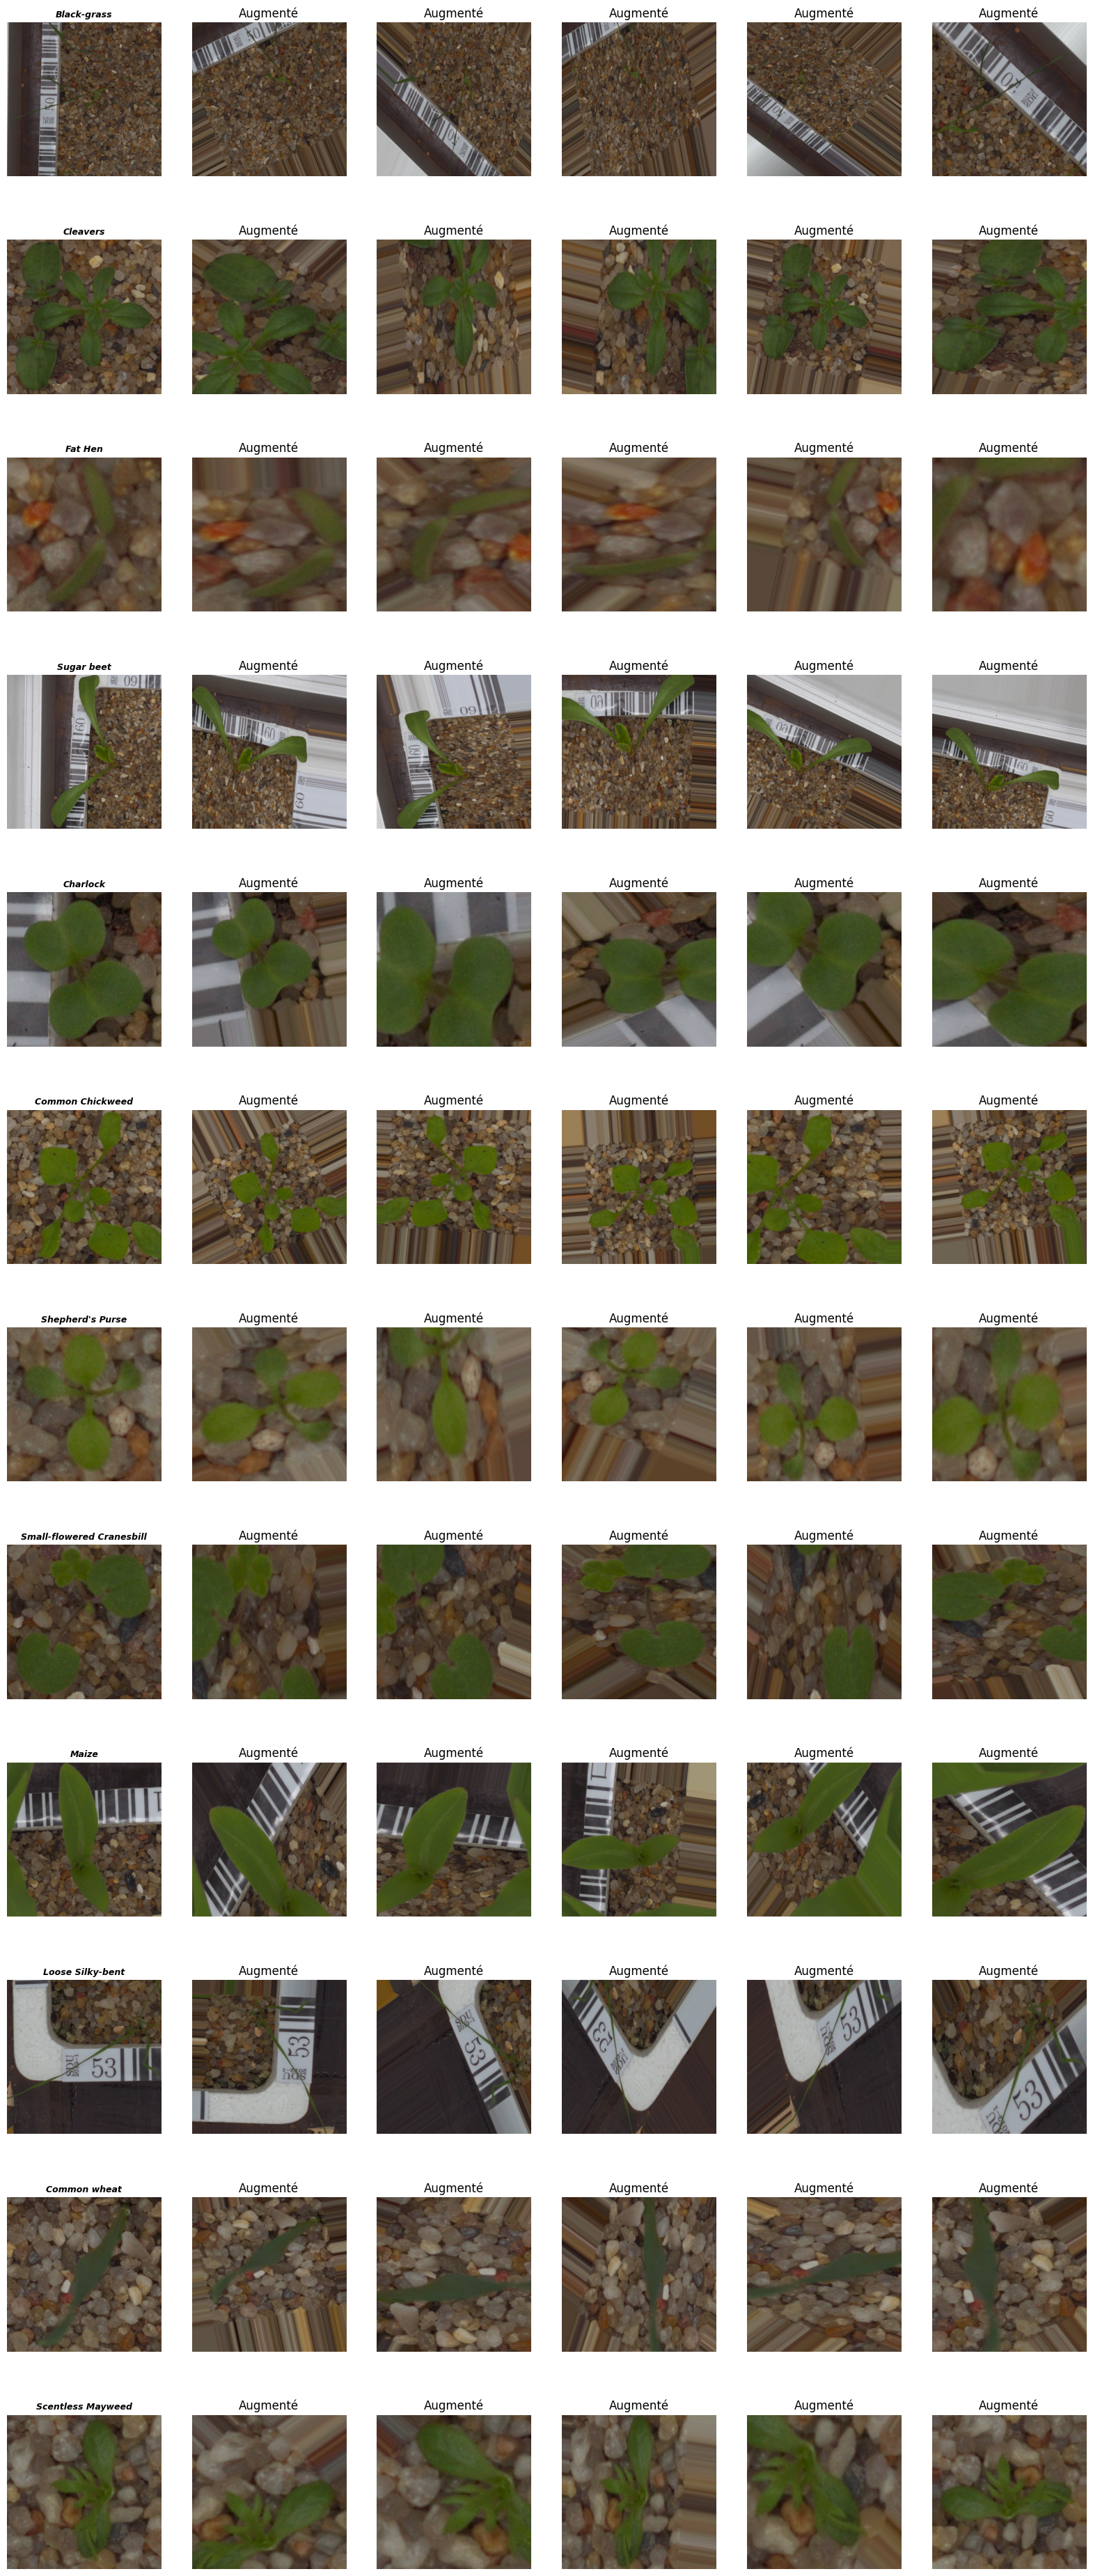

In [18]:
def indice(x, df, num_of_species=12):
    
    """
    Fonction retournant x indices d'images aléatoires par espèce d'un DataFrame
    """
    
    if num_of_species > 12:
        print("Il n'y a que 12 espèces.")
    
    elif x > min(df.species.value_counts()):
        print("Le dataset ne contient que ",df.species.value_counts().sort_values()[0], df.species.value_counts().sort_values().index[0], ".")
    
    else:
            indices = []
            for s in np.random.choice(df.species.unique(), size = num_of_species, replace=False):
                    indices += list(np.random.choice(df[df.species == s].index, size = x, replace=False))
            return indices 

#Visualisation de plusieurs résultats d'une augmentation de données

fig, ax = plt.subplots(12, 6, figsize=(20,48))

for i, idx in enumerate(indice(1, df_train)):
    ax[i, 0].imshow(io.imread(df_train.filepath[idx]))
    ax[i, 0].set_title(df_train.species[idx], fontstyle="italic", fontweight='bold', fontsize=9)
    ax[i, 0].axis("off")
        
    for j in range (1,6):
        ax[i, j].imshow(train_data_generator.random_transform(io.imread(df_train.filepath[idx])))
        ax[i, j].set_title("Augmenté")
        ax[i, j].axis("off")

In [10]:
# Modèle de base pour le Transfer Learning
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_shape)  #on ne veut que la partie feature extraction

# Freezer les couches du VGG19
for layer in base_model.layers:
    layer.trainable = False

print(base_model.summary())

# Instanciation du modèle selon une construction séquentielle
model = Sequential()
model.add(base_model) 
model.add(GlobalAveragePooling2D(name = "global_average_pooling2d"))
model.add(Dense(1024, activation="relu", name = "dense_1"))
model.add(Dropout(rate=0.2, name ="dropout_1"))
model.add(Dense(512, activation="relu", name = "dense_2"))
model.add(Dropout(rate=0.2, name = "dropout_2"))
model.add(Dense(num_classes, activation="softmax", name = "dense_3"))

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# Callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              mode='max', 
                              min_lr=0.00001)
                              
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0.01, 
                               patience=5, 
                               mode='min', 
                               verbose=1)  

callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [15]:
filepath = "model_TL_VGG19_freeze1.h5"
history = model.fit(train_data,                     
                                epochs=40,                       
                                validation_data= valid_data,                       
                                steps_per_epoch= df_train.shape[0] // batch_size,   # "L'augmentation se fera sur 138 lots
                                validation_steps = df_valid.shape[0] // batch_size,
                                callbacks=callbacks_list , verbose=True)

Epoch 1/40
138/138 [==============================] - ETA: 0s - loss: 2.2636 - accuracy: 0.2141 
Epoch 1: val_accuracy improved from -inf to 0.34375, saving model to model_TL_VGG19_freeze1.h5
138/138 [==============================] - 2601s 19s/step - loss: 2.2636 - accuracy: 0.2141 - val_loss: 1.8550 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/40
138/138 [==============================] - ETA: 0s - loss: 1.9341 - accuracy: 0.3196 
Epoch 2: val_accuracy improved from 0.34375 to 0.40144, saving model to model_TL_VGG19_freeze1.h5
138/138 [==============================] - 2834s 21s/step - loss: 1.9341 - accuracy: 0.3196 - val_loss: 1.7221 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 3/40
138/138 [==============================] - ETA: 0s - loss: 1.8174 - accuracy: 0.3499 
Epoch 3: val_accuracy improved from 0.40144 to 0.45673, saving model to model_TL_VGG19_freeze1.h5
138/138 [==============================] - 3181s 23s/step - loss: 1.8174 - accuracy: 0.3499 - val_loss: 1.6307 - val_accurac

In [12]:
# Poids optimaux
model.load_weights("model_TL_VGG19_freeze1.h5")
print(model.evaluate(test_data))

y_pred = model.predict(test_data, verbose=1).argmax(axis=1)
y_test = test_data.labels

21/21 [==============================] - 145s 7s/step - loss: 0.9804 - accuracy: 0.6677
[0.9804080724716187, 0.6676691770553589]
21/21 [==============================] - 184s 9s/step


                           precision    recall  f1-score   support

              Black-grass       0.55      0.30      0.39        37
                 Charlock       0.77      0.74      0.75        54
                 Cleavers       0.67      0.55      0.60        40
         Common Chickweed       0.78      0.86      0.82        86
             Common wheat       0.46      0.52      0.48        31
                  Fat Hen       0.51      0.55      0.53        65
         Loose Silky-bent       0.58      0.74      0.65        91
                    Maize       0.66      0.63      0.64        30
        Scentless Mayweed       0.72      0.74      0.73        73
         Shepherd's Purse       0.62      0.24      0.35        33
Small-flowered Cranesbill       0.85      0.81      0.83        69
               Sugar beet       0.67      0.73      0.70        56

                 accuracy                           0.67       665
                macro avg       0.65      0.62      0.62    

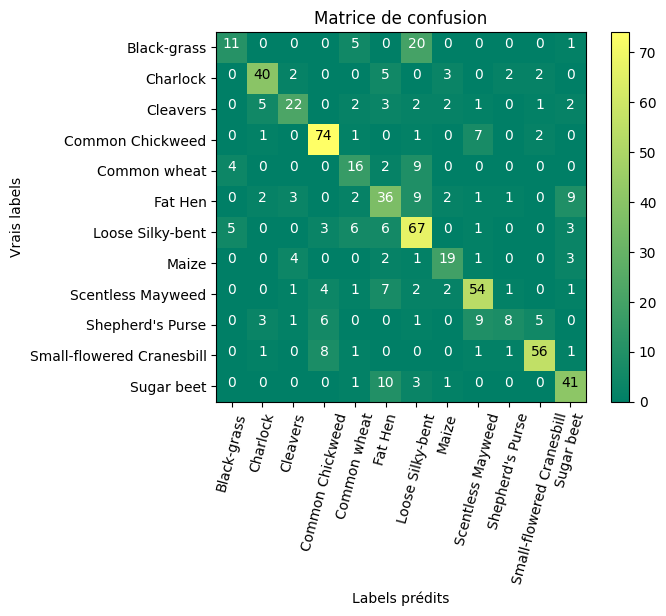

In [13]:
print(classification_report(y_test, y_pred, target_names=df.species.unique()))

matrix = confusion_matrix(y_test, y_pred)
classes = df.species.unique()                 

plt.figure()
plt.imshow(matrix, interpolation='nearest',cmap='summer') 
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=75)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, matrix[i, j],
             horizontalalignment="center",
             color="black" if matrix[i, j] > (matrix.max() / 2) else "white")

plt.ylabel('Vrais labels')        
plt.xlabel('Labels prédits');

### Fine Tuning : unfreeze du dernier bloc

In [10]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [136]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
filepath = "model_TL_VGG19_unfreeze1.h5"
history = model.fit(train_data,                   
                                epochs=30,                       
                                validation_data= valid_data,                       
                                steps_per_epoch= df_train.shape[0] // batch_size,   
                                validation_steps = df_valid.shape[0] // batch_size,
                                callbacks=callbacks_list , verbose=True)

Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 1.7794 - accuracy: 0.4201 
Epoch 1: val_accuracy improved from -inf to 0.66827, saving model to model_TL_VGG19_unfreeze1.h5
138/138 [==============================] - 1889s 14s/step - loss: 1.7794 - accuracy: 0.4201 - val_loss: 0.9151 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 2/30
138/138 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6397 
Epoch 2: val_accuracy improved from 0.66827 to 0.69712, saving model to model_TL_VGG19_unfreeze1.h5
138/138 [==============================] - 2050s 15s/step - loss: 1.0051 - accuracy: 0.6397 - val_loss: 0.8586 - val_accuracy: 0.6971 - lr: 1.0000e-04
Epoch 3/30
138/138 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.6970 
Epoch 3: val_accuracy improved from 0.69712 to 0.72115, saving model to model_TL_VGG19_unfreeze1.h5
138/138 [==============================] - 2148s 16s/step - loss: 0.8668 - accuracy: 0.6970 - val_loss: 0.7400

Epoch 26/30
138/138 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.9057 
Epoch 26: val_accuracy did not improve from 0.92548
138/138 [==============================] - 1905s 14s/step - loss: 0.2701 - accuracy: 0.9057 - val_loss: 0.2274 - val_accuracy: 0.9231 - lr: 2.5000e-05
Epoch 27/30
138/138 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9104 
Epoch 27: val_accuracy did not improve from 0.92548

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
138/138 [==============================] - 1906s 14s/step - loss: 0.2538 - accuracy: 0.9104 - val_loss: 0.2497 - val_accuracy: 0.9159 - lr: 2.5000e-05
Epoch 28/30
138/138 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9198 
Epoch 28: val_accuracy did not improve from 0.92548
138/138 [==============================] - 1897s 14s/step - loss: 0.2259 - accuracy: 0.9198 - val_loss: 0.1947 - val_accuracy: 0.9183 - lr: 1.2500e-05
Epoch 29/30
138/138

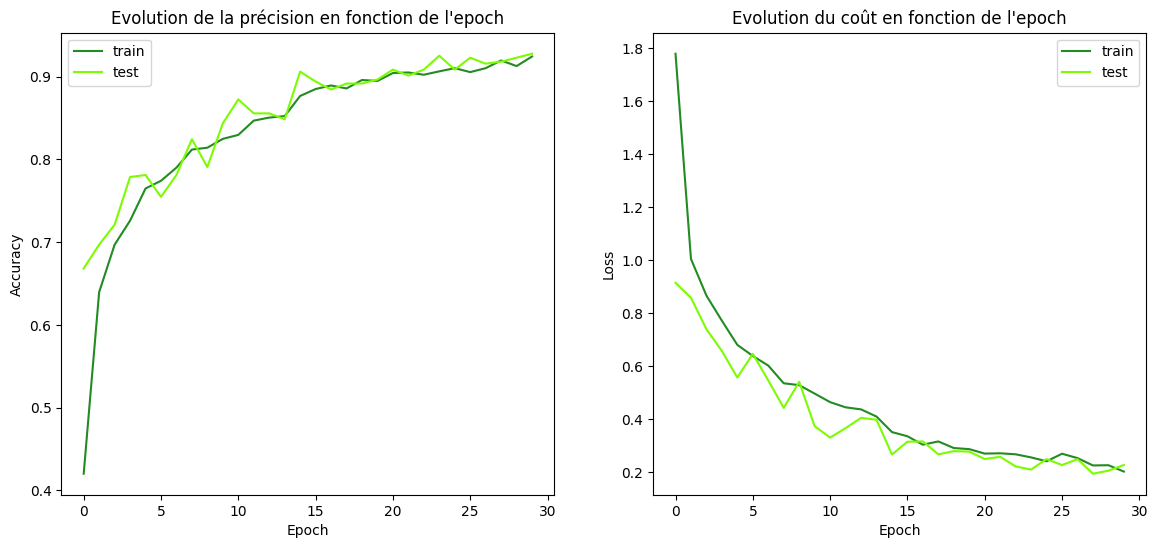

In [45]:
#Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(history.history['accuracy'], color='forestgreen')                    
ax[0].plot(history.history['val_accuracy'], color='lawngreen')                      


ax[0].set_title("Evolution de la précision en fonction de l'epoch")                
ax[0].set_xlabel("Epoch")           
ax[0].set_ylabel("Accuracy")        
ax[0].legend(['train', 'test'], loc='best');                                                               

ax[1].plot(history.history['loss'], color='forestgreen')
ax[1].plot(history.history['val_loss'], color='lawngreen')
ax[1].set_title("Evolution du coût en fonction de l'epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(['train', 'test'], loc='best');

In [46]:
history = model.fit(train_data,                   
                                epochs=20,                       
                                validation_data= valid_data,                       
                                steps_per_epoch= df_train.shape[0] // batch_size,   
                                validation_steps = df_valid.shape[0] // batch_size,
                                callbacks=callbacks_list , verbose=True)

Epoch 1/20
138/138 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9234 
Epoch 1: val_accuracy did not improve from 0.92788
138/138 [==============================] - 1611s 12s/step - loss: 0.2157 - accuracy: 0.9234 - val_loss: 0.2264 - val_accuracy: 0.9159 - lr: 1.2500e-05
Epoch 2/20
138/138 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9129 
Epoch 2: val_accuracy did not improve from 0.92788
138/138 [==============================] - 2094s 15s/step - loss: 0.2226 - accuracy: 0.9129 - val_loss: 0.2040 - val_accuracy: 0.9279 - lr: 1.2500e-05
Epoch 3/20
138/138 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9275 
Epoch 3: val_accuracy improved from 0.92788 to 0.93750, saving model to model_TL_VGG19_unfreeze1.h5
138/138 [==============================] - 1987s 14s/step - loss: 0.2035 - accuracy: 0.9275 - val_loss: 0.2213 - val_accuracy: 0.9375 - lr: 1.2500e-05
Epoch 4/20
138/138 [==============================] - 

KeyboardInterrupt: 

### Unfreeze du bloc suivant

In [9]:
for layer in base_model.layers[-10:-5]:
    layer.trainable = True

In [72]:
model.compile(tf.keras.optimizers.Adam(learning_rate=2.5e-05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = "model_TL_VGG19_unfreeze2.h5"
history = model.fit(train_data,                   
                                epochs=15,                       
                                validation_data= valid_data,                       
                                steps_per_epoch= df_train.shape[0] // batch_size,   
                                validation_steps = df_valid.shape[0] // batch_size,
                                callbacks=callbacks_list , verbose=True)

Epoch 1/15
138/138 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9193 
Epoch 1: val_accuracy improved from 0.92308 to 0.92548, saving model to model_TL_VGG19_unfreeze2.h5
138/138 [==============================] - 4025s 29s/step - loss: 0.2113 - accuracy: 0.9193 - val_loss: 0.1916 - val_accuracy: 0.9255 - lr: 2.5000e-05
Epoch 2/15
138/138 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9295 
Epoch 2: val_accuracy did not improve from 0.92548
138/138 [==============================] - 4004s 29s/step - loss: 0.1923 - accuracy: 0.9295 - val_loss: 0.2575 - val_accuracy: 0.9014 - lr: 2.5000e-05
Epoch 3/15
138/138 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9325 
Epoch 3: val_accuracy improved from 0.92548 to 0.93029, saving model to model_TL_VGG19_unfreeze2.h5
138/138 [==============================] - 3999s 29s/step - loss: 0.1892 - accuracy: 0.9325 - val_loss: 0.1962 - val_accuracy: 0.9303 - lr: 2.5000e-05
Epoch

In [13]:
model.evaluate(test_data)

21/21 [==============================] - 203s 10s/step - loss: 0.1959 - accuracy: 0.9398


[0.19590921700000763, 0.9398496150970459]

In [148]:
y_pred = model.predict(test_data, verbose=1).argmax(axis=1)
y_test = test_data.labels

21/21 [==============================] - 472s 23s/step


In [14]:
y_pred = model.predict(test_data, verbose=1).argmax(axis=1)
y_test = test_data.labels

21/21 [==============================] - 255s 12s/step


                           precision    recall  f1-score   support

              Black-grass       0.69      0.84      0.76        37
                 Charlock       0.96      0.96      0.96        54
                 Cleavers       0.95      0.90      0.92        40
         Common Chickweed       0.97      0.99      0.98        86
             Common wheat       0.91      0.94      0.92        31
                  Fat Hen       0.97      0.98      0.98        65
         Loose Silky-bent       0.94      0.88      0.91        91
                    Maize       0.91      0.97      0.94        30
        Scentless Mayweed       0.96      0.95      0.95        73
         Shepherd's Purse       0.96      0.82      0.89        33
Small-flowered Cranesbill       0.99      0.99      0.99        69
               Sugar beet       0.98      0.98      0.98        56

                 accuracy                           0.94       665
                macro avg       0.93      0.93      0.93    

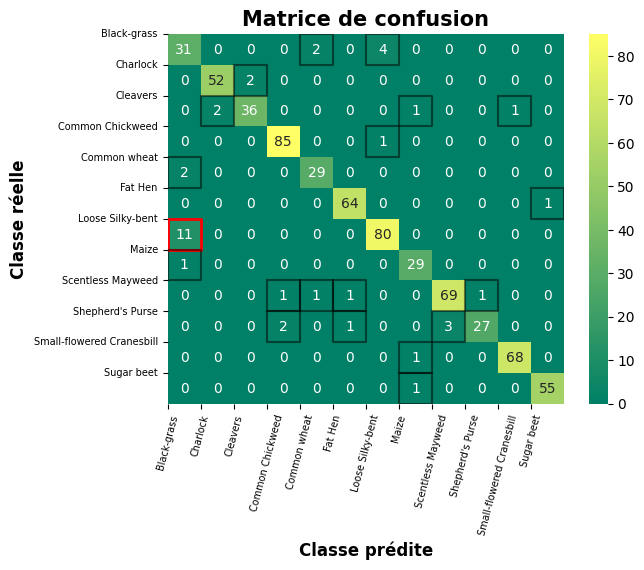

In [152]:
print(classification_report(y_test, y_pred, target_names=df.species.unique()))

sns.heatmap(matrix, annot=True,cmap="summer")
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)

for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    if (i!=j) and (matrix[i,j] !=0):
        if (matrix[i,j] > matrix.mean()):
            plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
        else:
            plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    

plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)

plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

### Unfreeze des 3 blocs restants

In [10]:
for layer in base_model.layers[:12]:
    layer.trainable = True

In [13]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='min', min_delta=0.01)
                              
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1)  

filename= "model_TL_VGG19_unfreeze3.h5"
checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(train_data,                   
                                epochs=30,                       
                                validation_data= valid_data,                       
                                steps_per_epoch= df_train.shape[0] // batch_size,   
                                validation_steps = df_valid.shape[0] // batch_size,
                                callbacks=callbacks_list , verbose=True)

Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9495 
Epoch 1: val_accuracy improved from -inf to 0.93990, saving model to model_TL_VGG19_unfreeze3.h5
138/138 [==============================] - 2538s 18s/step - loss: 0.1385 - accuracy: 0.9495 - val_loss: 0.2000 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 2/30
138/138 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9504 
Epoch 2: val_accuracy did not improve from 0.93990
138/138 [==============================] - 3078s 22s/step - loss: 0.1377 - accuracy: 0.9504 - val_loss: 0.2119 - val_accuracy: 0.9279 - lr: 1.0000e-04
Epoch 3/30
138/138 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9507 
Epoch 3: val_accuracy did not improve from 0.93990
138/138 [==============================] - 3184s 23s/step - loss: 0.1397 - accuracy: 0.9507 - val_loss: 0.2348 - val_accuracy: 0.9279 - lr: 1.0000e-04
Epoch 4/30
138/138 [==============================] - ETA

N.B : Le temps d'entrainement pouvant atteindre une quinzaine d'heures par defreeze, certains entraînement ont été interrompus du fait d'un bug de l'ordinateur.

Le dernier defreeze est documenté dans le notebook "VGG19 Final Unfreeze + Grad-CAM.ipynb"